[OpenLLMetry Integration via OpenTelemetry](https://langfuse.com/guides/cookbook/otel_integration_openllmetry)

Langfuse provides a backend built on OpenTelemetry for ingesting trace data, and you can use different instrumentation libraries to export traces from your applications. In this guide, we showcase how to instrument your LLM application using the OpenLLMetry instrumentation library by Traceloop.

    **About OpenLLMetry**: OpenLLMetry is an open source project that simplifies monitoring and debugging of your LLM application. It leverages OpenTelemetry to collect trace data in a non-intrusive manner.

### Step 1: Install Dependencies

In [1]:
%pip install openai traceloop-sdk langfuse

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/d4/db/5ff1cd6c5ca1d12ecf1b73be16fbb2a8af2114ee46d4b0e6d4b23f4f4db7/opentelemetry_instrumentation-0.58b0-py3-none-any.whl (33 kB)
INFO: pip is looking at multiple versions of opentelemetry-instrumentation to determine which version is compatible with other requirements. This could take a while.
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/d0/6f/f20cd1542959f43fb26a5bf9bb18cd81a1ea0700e8870c8f369bd07f5c65/opentelemetry_instrumentation-0.57b0-py3-none-any.whl (32 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/26/aa/2328f27200b8e51640d4d7ff5343ba6a81ab7d2650a9f574db016aae4adf/opentelemetry_instrumentation-0.56b0-py3-none-any.whl (31 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/60/7d/8ddfda1506c2fcca137924d5688ccabffa1aed9ec0955b

  DEPRECATION: Building 'cuid' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'cuid'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai 0.157.0 requires litellm==1.74.9, but you have litellm 1.76.1 which is incompatible.
deepeval 3.2.5 requires click<8.2.0,>=8.0.0, but you have click 8.2.1 which is incompatible.
deepeval 3.2.5 requires tenacity<=9.0.0, but you have tenacity 9.1.2 which is incompatible.
langfuse-haystack 2.2.0 requires langfuse<3.0.0,>=2.9.0, but you have langfuse 3.3.4 which is in

### Step 2: Configure Environment Variables

In [2]:
import os
import base64


# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Build Basic Auth header.
LANGFUSE_AUTH = base64.b64encode(
    f"{os.environ.get('LANGFUSE_PUBLIC_KEY')}:{os.environ.get('LANGFUSE_SECRET_KEY')}".encode()
).decode()

# Configure OpenTelemetry endpoint & headers
os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = (
    os.environ.get("LANGFUSE_HOST") + "/api/public/otel"
)
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"Authorization=Basic {LANGFUSE_AUTH}"

# Your openai key
# os.environ["OPEN_AI_URL"] = "https://open.bigmodel.cn/api/paas/v4/"
os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

In [3]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


### Step 3: Initialize Instrumentation

Next, initialize the OpenLLMetry instrumentation using the traceloop-sdk. Using disable_batch=True is recommended if you run this code in a notebook as traces are sent immediately without waiting for batching.

In [4]:
from traceloop.sdk import Traceloop
 
Traceloop.init(disable_batch=True,
               api_endpoint=os.environ.get("OTEL_EXPORTER_OTLP_ENDPOINT"),
               headers=os.environ.get(f"Authorization=Basic {LANGFUSE_AUTH}"),)

Overriding of current TracerProvider is not allowed
ERROR:root:Error initializing MistralAI instrumentor: No module named 'mistralai.models.chat_completion'


### Step 4: Execute a Sample LLM Request

In [5]:
from openai import OpenAI
 
openai_client = OpenAI()
 
chat_completion = openai_client.chat.completions.create(
    messages=[
        {
          "role": "user",
          "content": "What is LLM Observability?",
        }
    ],
    model="glm-4.5-flash",
)
 
print(chat_completion)

ChatCompletion(id='20250915101327c586b5bc9ac44a02', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='**LLM Observability** refers to the practice of monitoring, understanding, and troubleshooting the behavior and performance of **Large Language Models (LLMs)** throughout their lifecycle – from development and training to deployment and inference. It\'s the set of tools, techniques, and processes that provide **visibility into the "black box"** of how an LLM system is actually performing in production.\n\nThink of it as the **dashboard and diagnostic toolkit** specifically designed for the unique complexities of LLMs, going far beyond traditional application monitoring.\n\nHere\'s a breakdown of its key aspects and why it\'s crucial:\n\n### Core Components of LLM Observability\n\n1.  **Monitoring:**\n    *   **System Health:** Track infrastructure (CPU, GPU, memory, network latency, throughput) for the serving infrastructure (e.g., inf

### Step 5: View the Trace in Langfuse

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/de64b203125e80bdfebfc46435f1637e?timestamp=2025-09-15T02:13:25.127Z&display=details)

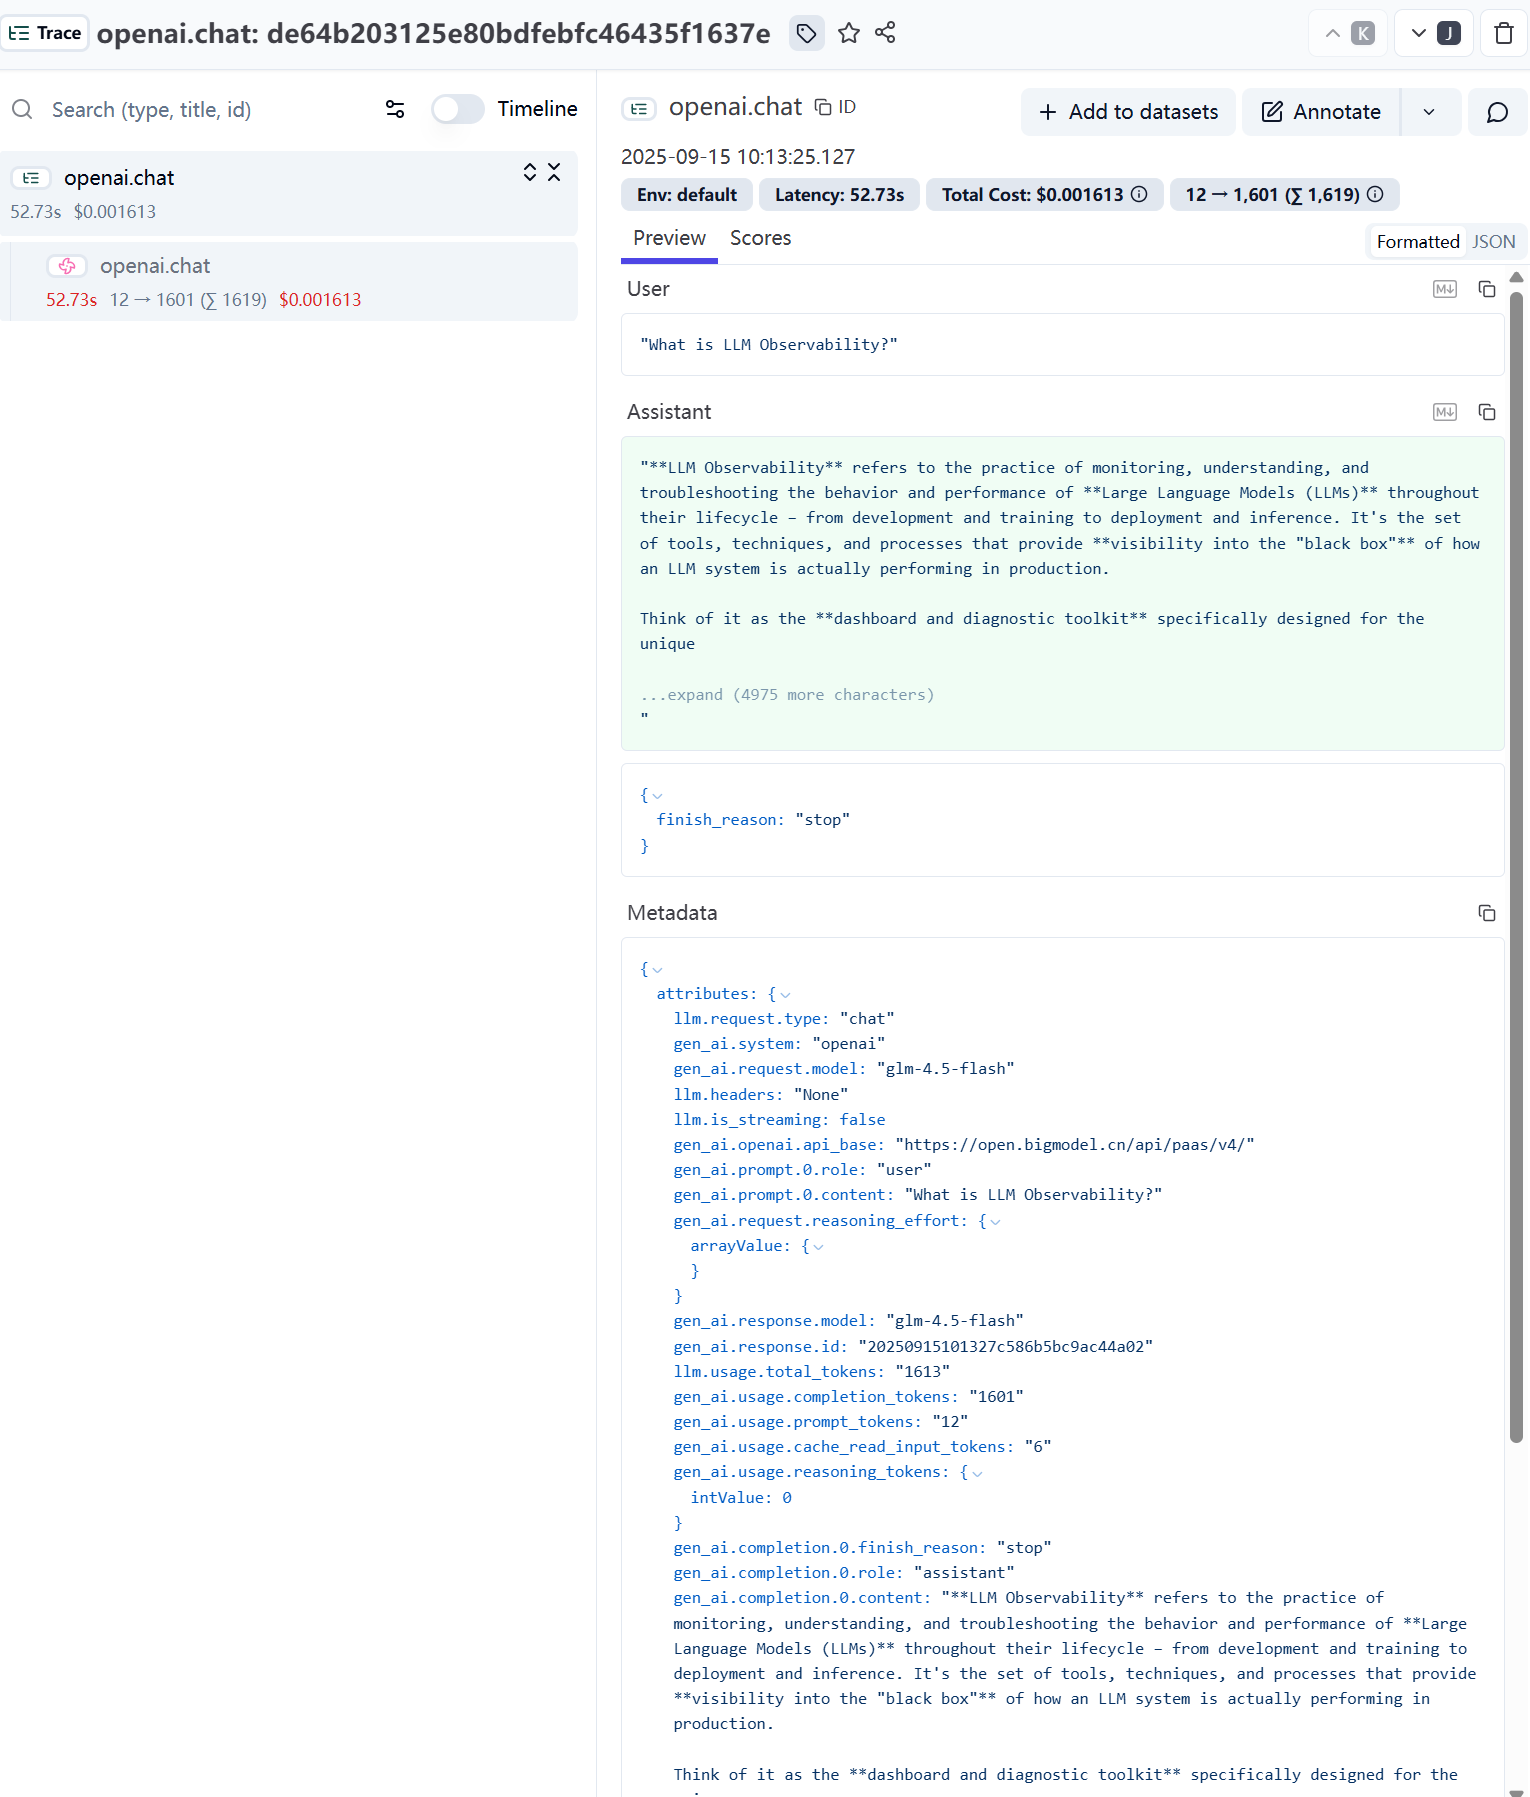